# Analyse der Einflussfaktoren auf die Schlafqualität mittels maschinellen Lernens

Dieses Notebook enthält die vollständige Analyse für die Projektarbeit im Rahmen der EN ISO / IEC 17024-Zertifizierungsprüfung.

## 1. Einleitung

Die Schlafqualität ist ein wesentlicher Faktor für die menschliche Gesundheit und Leistungsfähigkeit. In dieser Analyse untersuchen wir die verschiedenen Einflussfaktoren auf die Schlafqualität mithilfe von Methoden des maschinellen Lernens.


In [4]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

sns.set_theme()
sns.set(font_scale=1.2)

# 2. Beschreibung des Datensatzes


In [5]:
# Laden des Datensatzes
file_path = "/Users/tommygrace/Desktop/sleep_quality_project/data/wearable_tech_sleep_quality_1.csv"
df = pd.read_csv(file_path)

# Anzeigen der ersten Zeilen und Informationen über den Datensatz
print(df.head())
print(df.info())

# Überprüfung auf fehlende Werte
print(df.isnull().sum())

   Heart_Rate_Variability  Body_Temperature  Movement_During_Sleep  \
0               79.934283         37.199678               1.324822   
1               67.234714         36.962317               1.855481   
2               82.953771         36.529815               1.207580   
3              100.460597         36.176532               1.692038   
4               65.316933         36.849112               0.106385   

   Sleep_Duration_Hours  Sleep_Quality_Score  Caffeine_Intake_mg  \
0              4.638289                  1.0          107.624032   
1              6.209422                  1.0          104.658589   
2              6.879592                 10.0            0.000000   
3             10.331531                  1.0          116.990981   
4              8.334830                  1.0          223.282908   

   Stress_Level  Bedtime_Consistency  Light_Exposure_hours  
0      2.771837             0.657037              7.933949  
1      3.738138             0.144464            

### 3.2 Erstellung neuer Features
- **Caffeine_Squared**: Quadrat der Koffeinaufnahme, um mögliche nichtlineare Effekte zu erfassen.
- **Caffeine_Stress_Interaction**: Interaktion zwischen Koffeinaufnahme und Stresslevel.
- **Sleep_Efficiency**: Verhältnis von Schlafdauer zur im Bett verbrachten Zeit, um die Effektivität des Schlafs zu messen.
- **Movement_Stress_Index**: Produkt aus Bewegung im Schlaf und Stresslevel.
- **Light_Sleep_Ratio**: Verhältnis von Lichtexposition zur Schlafdauer.

In [6]:
# Erstellung neuer Features
df['Caffeine_Squared'] = df['Caffeine_Intake_mg'] ** 2
df['Caffeine_Stress_Interaction'] = df['Caffeine_Intake_mg'] * df['Stress_Level']
df['Sleep_Efficiency'] = df['Sleep_Duration_Hours'] / 8  # Annahme: 8 Stunden als Referenz
df['Movement_Stress_Index'] = df['Movement_During_Sleep'] * df['Stress_Level']
df['Light_Sleep_Ratio'] = df['Light_Exposure_hours'] / df['Sleep_Duration_Hours']

### 3.3 Standardisierung

Um die Wertebereiche der verschiedenen Features zu vereinheitlichen und die Modellleistung zu verbessern, wurden die Daten standardisiert. Die Standardisierung transformiert die Features zu einem Mittelwert von 0 und einer Standardabweichung von 1, um eine bessere Vergleichbarkeit zu gewährleisten. Die Zielvariable (Sleep_Quality_Score) wurde nicht standardisiert, um die Interpretierbarkeit der Vorhersagen zu erhalten.

In [7]:
# Standardisierung der Features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['Sleep_Quality_Score'])), columns=df.columns[:-1])
df_scaled['Sleep_Quality_Score'] = df['Sleep_Quality_Score']

## 4. Explorative Datenanalyse (EDA)

- **Deskriptive Statistiken**: Die meisten Variablen weisen eine normale oder leicht schiefe Verteilung auf.
- **Korrelationsmatrix**: Eine starke negative Korrelation wurde zwischen der Koffeinaufnahme und dem Schlafqualitätsscore festgestellt.
- **Verteilungen der Hauptvariablen**: Visualisierungen der Variablenverteilungen halfen, potenzielle Zusammenhänge und Ausreißer zu identifizieren.

       Heart_Rate_Variability  Body_Temperature  Movement_During_Sleep  \
count             1000.000000       1000.000000            1000.000000   
mean                70.386641         36.535418               2.005834   
std                 19.584319          0.498727               0.983454   
min                  5.174653         35.029806              -1.019512   
25%                 57.048194         36.196879               1.352000   
50%                 70.506012         36.531539               1.999749   
75%                 82.958878         36.864441               2.660915   
max                147.054630         38.096554               5.926238   

       Sleep_Duration_Hours  Sleep_Quality_Score  Caffeine_Intake_mg  \
count           1000.000000          1000.000000         1000.000000   
mean               7.471921             2.592946          148.260148   
std                1.540699             2.979500           94.031760   
min                3.105827             1.000

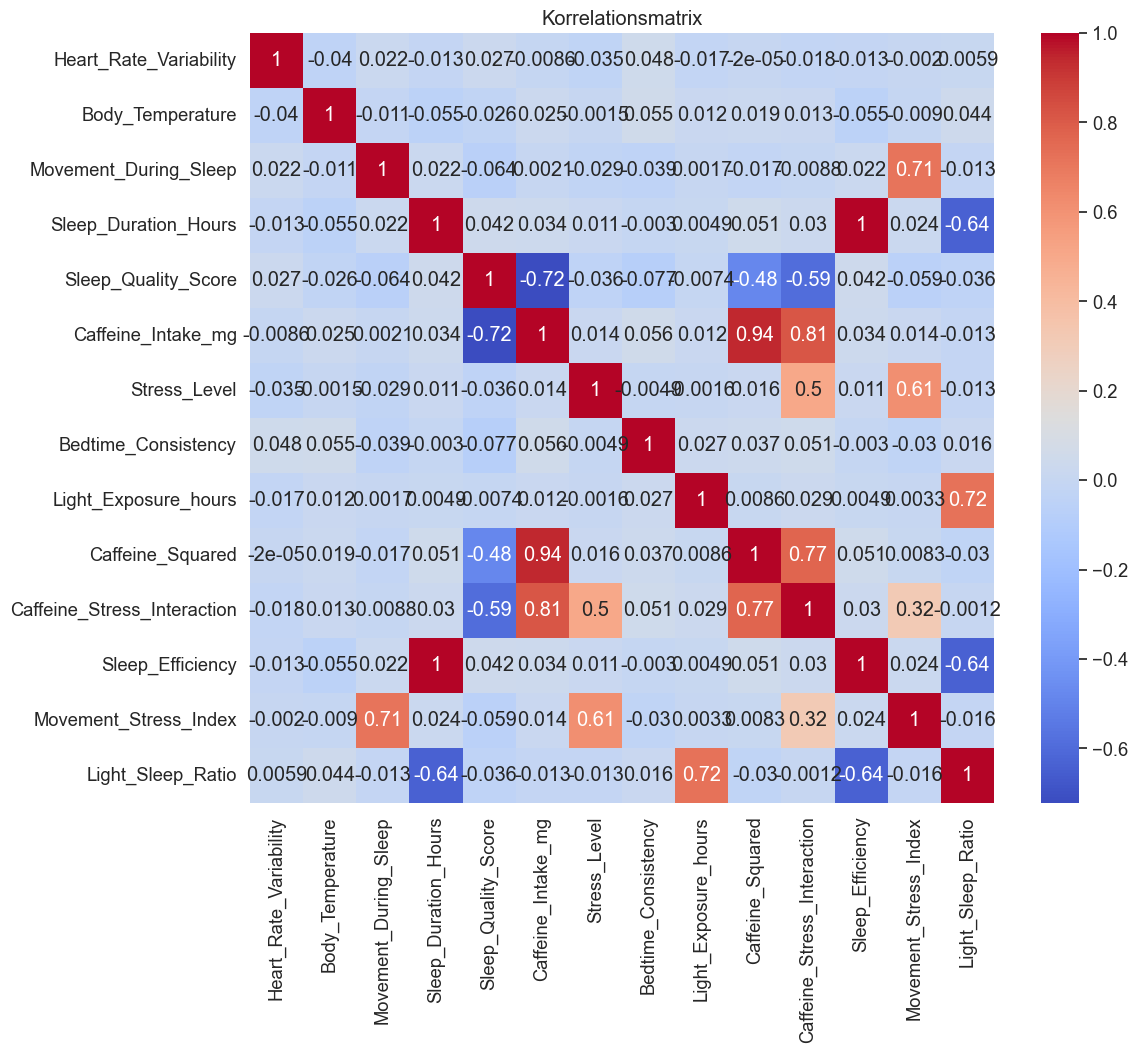

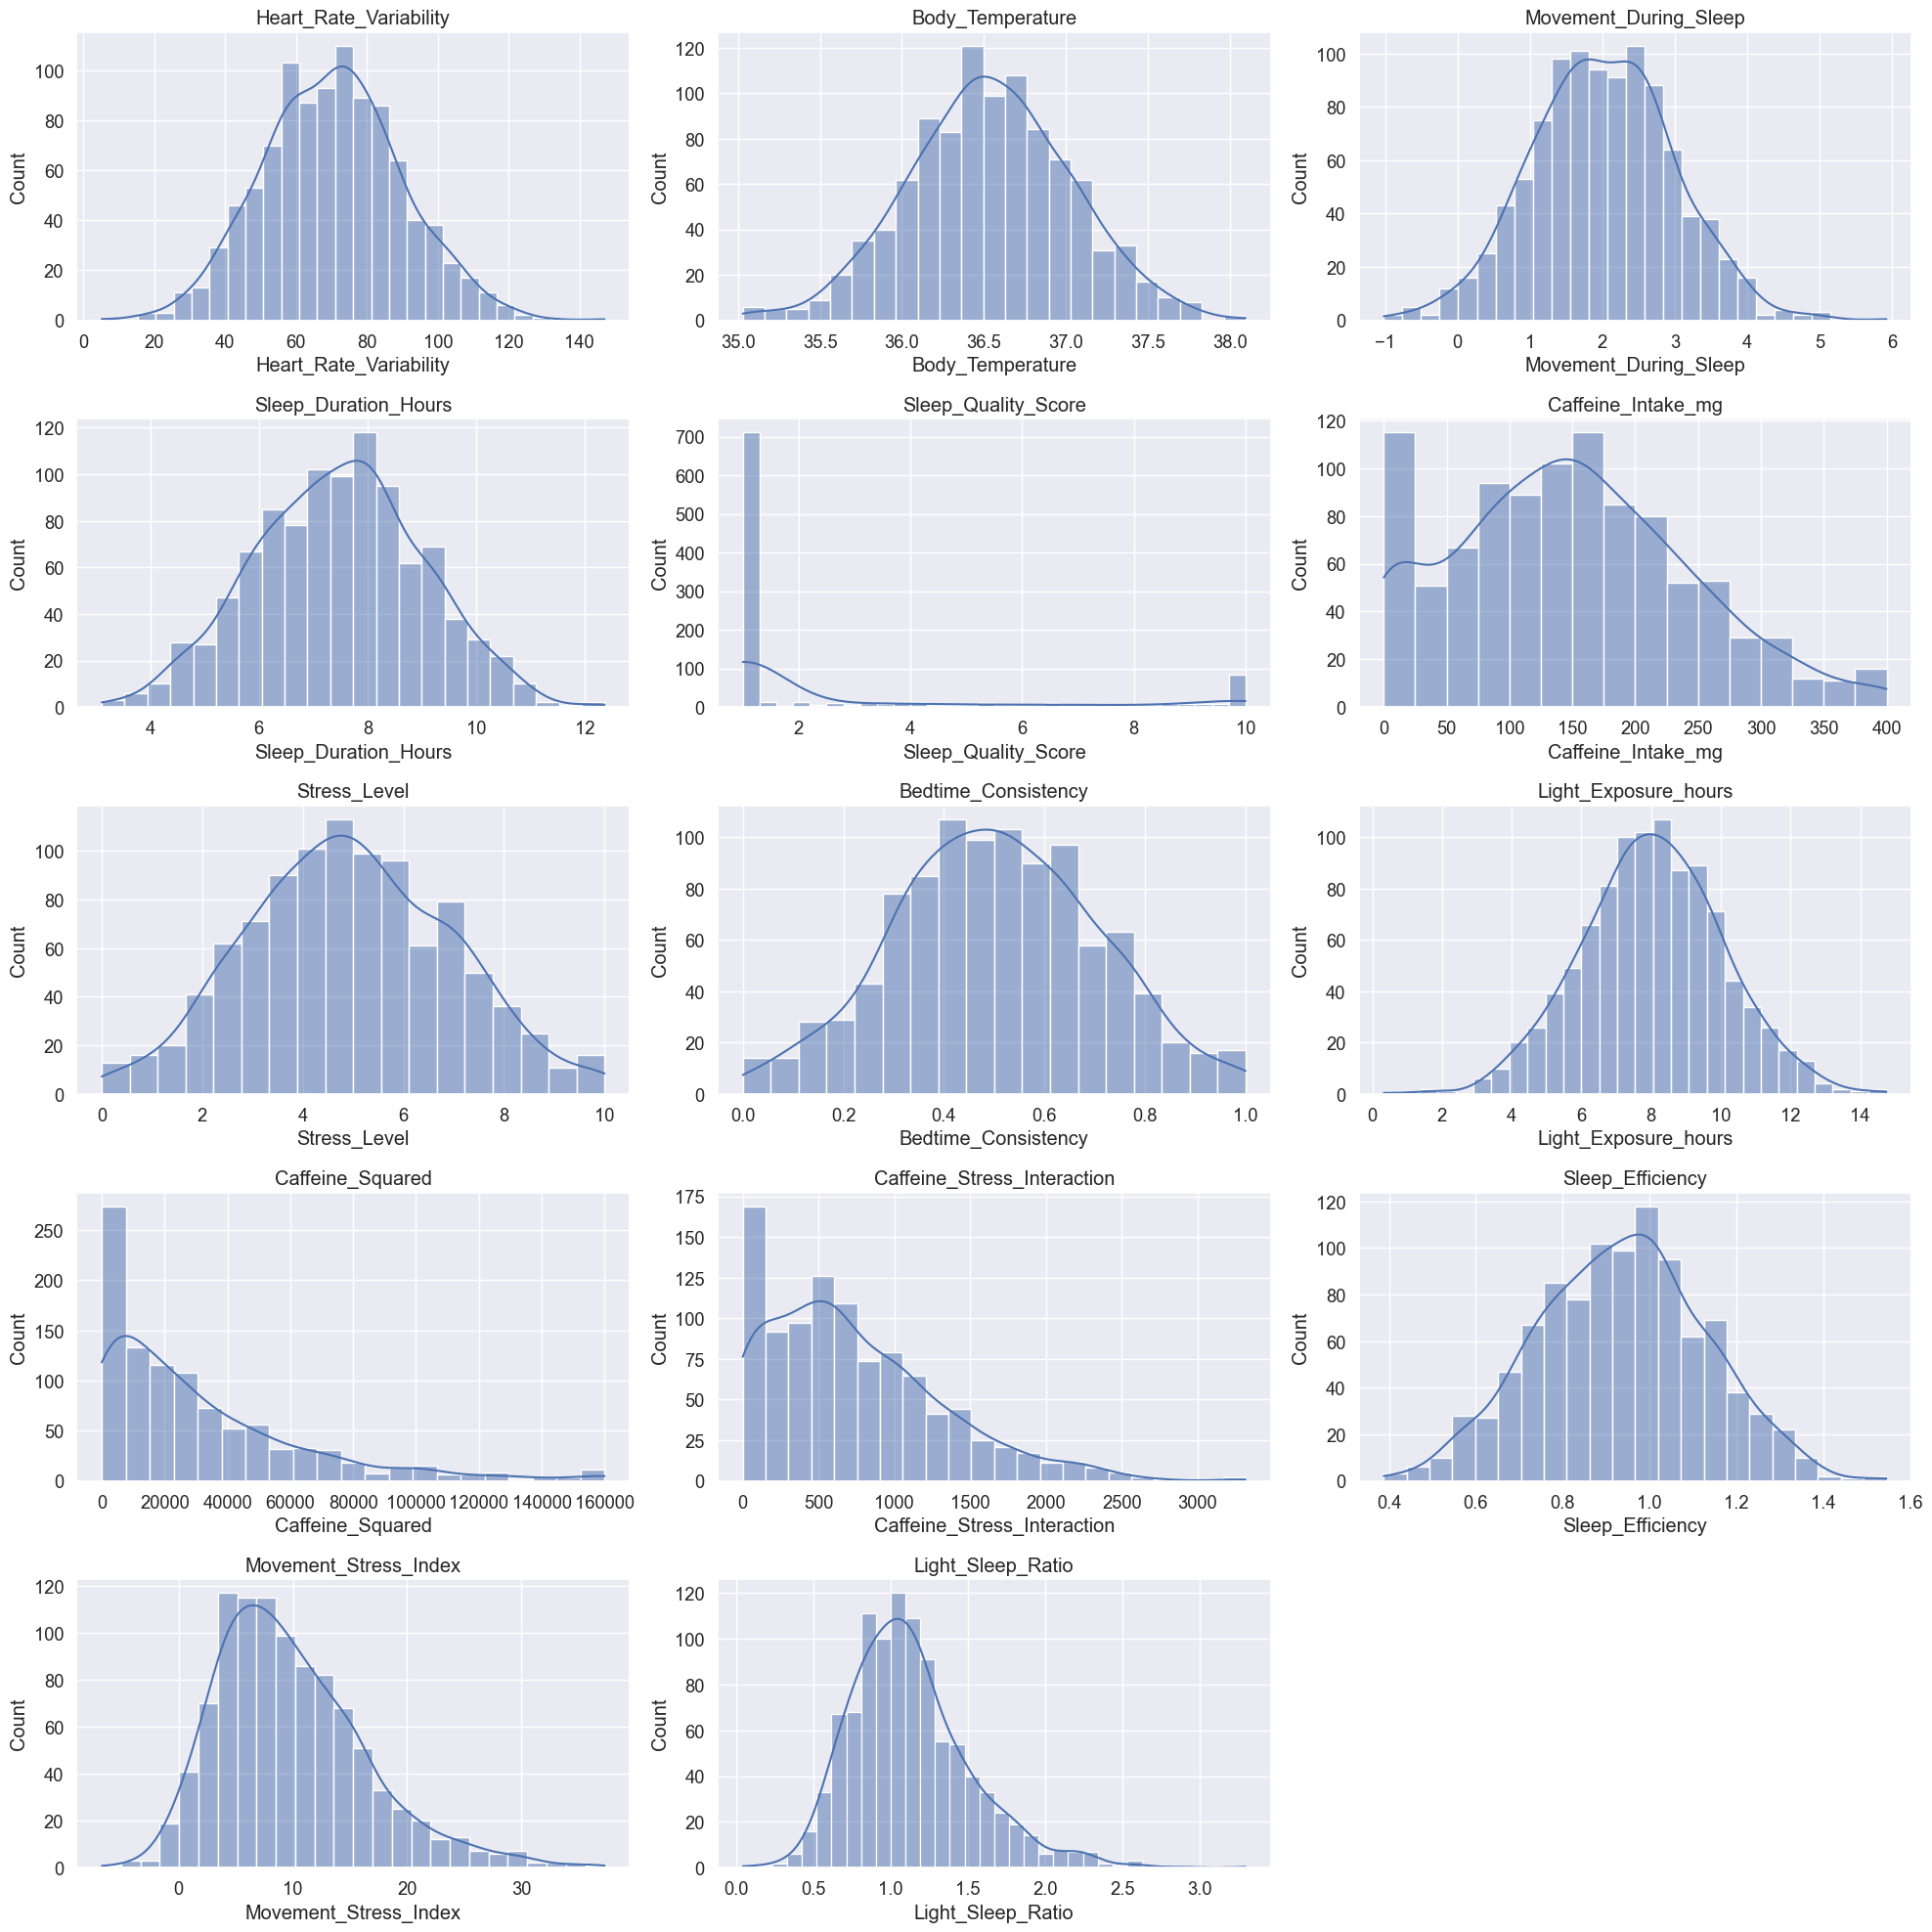

In [9]:
# Deskriptive Statistiken
print(df.describe())

# Korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()

# Verteilungen der Hauptvariablen
num_vars = len(df.columns)
fig, axes = plt.subplots((num_vars + 2) // 3, 3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

Korrelationsmatrix

Starke negative Korrelation zwischen Caffeine_Intake_mg und Sleep_Quality_Score (-0,72): Eine höhere Koffeinaufnahme ist stark mit einer schlechteren Schlafqualität verbunden. Diese Beziehung ist eines der wichtigsten Ergebnisse und deutet darauf hin, dass Koffein ein wesentlicher Faktor bei der Beeinträchtigung der Schlafqualität ist.

1.  Positive Korrelation zwischen Caffeine_Squared und Caffeine_Intake_mg (0,94): Dies ist erwartungsgemäß, da Caffeine_Squared einfach das Quadrat der Koffeinaufnahme ist.

2. Positive Korrelation zwischen Movement_Stress_Index und Movement_During_Sleep (0,71): Die Bewegung während des Schlafs in Kombination mit dem Stresslevel könnte den Schlaf erheblich beeinflussen.


Histogramme der Hauptvariablen

- Heart_Rate_Variability: Die Verteilung ist fast normal verteilt mit einem Mittelwert von ca. 70. Dies zeigt, dass die Herzfrequenzvariabilität bei den meisten Teilnehmern im normalen Bereich liegt.

- Body_Temperature: Normalverteilung bei ca. 36,5°C, was die typische Körpertemperatur während des Schlafes widerspiegelt.
Movement_During_Sleep: Die meisten Teilnehmer zeigen relativ moderate Bewegungen während des Schlafes. Einige haben jedoch hohe Bewegungswerte, was möglicherweise zu einer schlechteren Schlafqualität beiträgt.

- Sleep_Quality_Score: Der Sleep_Quality_Score ist stark rechtsschief verteilt, wobei viele Teilnehmer eine niedrige Schlafqualität von 1 haben, was darauf hinweist, dass die Schlafqualität bei den meisten gering ist.

- Caffeine_Intake_mg: Die Koffeinaufnahme variiert stark, wobei die Verteilung leicht rechtsschief ist. Dies zeigt, dass es einige Teilnehmer gibt, die eine sehr hohe Koffeinaufnahme haben.

- Stress_Level: Die Stresslevel-Verteilung zeigt eine annähernd normale Verteilung mit einem Mittelwert von etwa 5. Höhere Stresslevel könnten die Schlafqualität negativ beeinflussen.

- Light_Exposure_hours: Die Lichtexpositionswerte vor dem Schlafen sind unterschiedlich verteilt, wobei viele Teilnehmer eine moderate Lichtexposition haben. Eine erhöhte Lichtexposition könnte die Schlafqualität verschlechtern.

- Bedtime_Consistency: Die Verteilung ist symmetrisch, was zeigt, dass die Schlafenszeit bei einigen konstant, bei anderen jedoch variabel ist. Konsistenz könnte zu einer besseren Schlafqualität beitragen.

- Sleep_Efficiency: Die meisten Teilnehmer liegen nahe am Referenzwert 1 (was ideal ist), aber einige haben niedrigere Effizienzwerte, was möglicherweise auf gestörten Schlaf hinweist.


Schlussfolgerungen aus den Verteilungen

Koffeinaufnahme ist der stärkste negative Einflussfaktor auf die Schlafqualität. Maßnahmen zur Reduktion des Koffeinkonsums, besonders spät am Tag, könnten potenziell zur Verbesserung der Schlafqualität beitragen.

Bewegung während des Schlafs und Stresslevel haben auch einen erkennbaren Einfluss auf die Schlafqualität, was darauf hinweist, dass eine Reduzierung der Stressbelastung durch Entspannungsübungen die Schlafqualität verbessern könnte.
Lichtexposition vor dem Schlafengehen sollte minimiert werden, um die Schlafqualität zu verbessern, insbesondere blaues Licht sollte vermieden werden.

## 5. Clustering-Analyse

Mithilfe von K-Means Clustering wurden verschiedene Cluster analysiert, um Muster in den Daten zu erkennen.

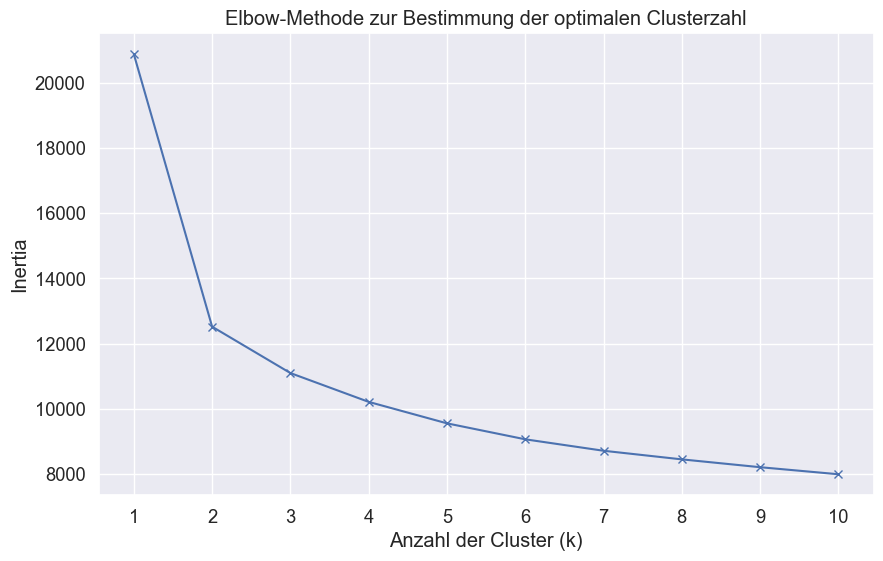

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

inertias = []
k_range = range(1, 11)  # Betrachten Sie Cluster von 1 bis 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung der optimalen Clusterzahl')
plt.xticks(k_range)
plt.grid(True)
plt.show()

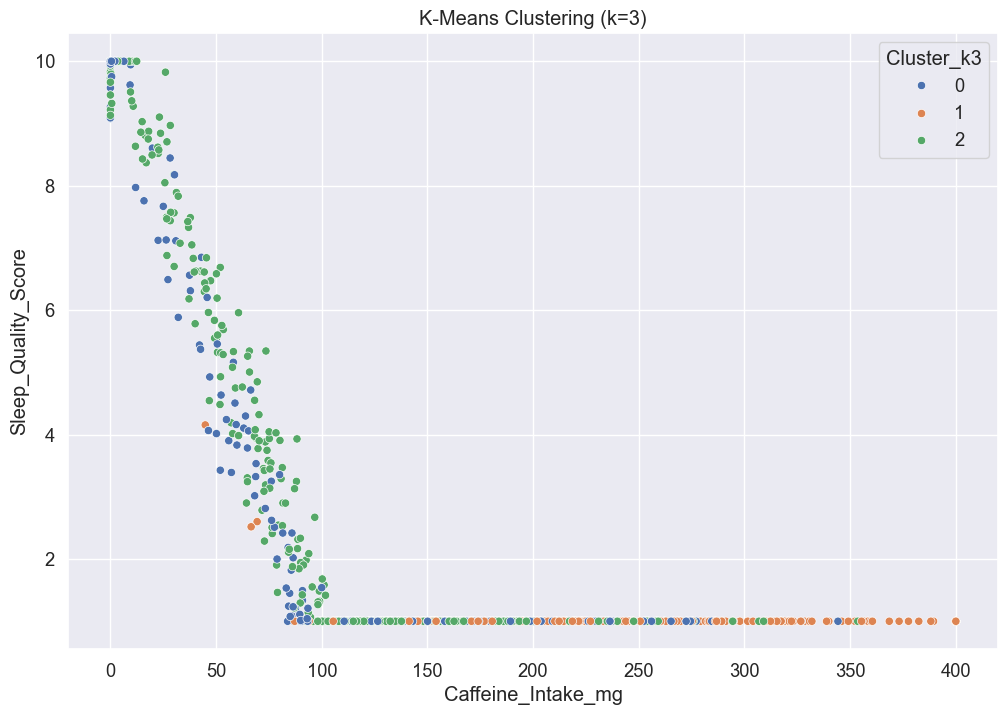

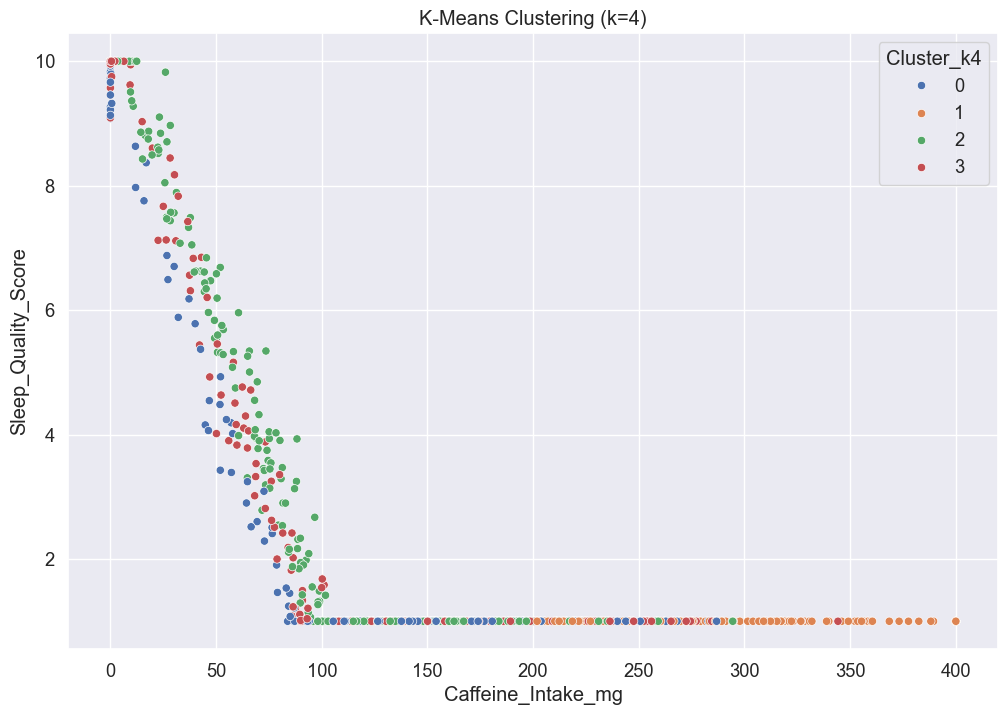


Cluster-Analyse für k=3:
            Caffeine_Intake_mg  Sleep_Duration_Hours  Sleep_Quality_Score
Cluster_k3                                                               
0                   130.346344              5.874686             2.503498
1                   246.249734              7.745964             1.027399
2                   112.143660              8.340324             3.405343

Cluster-Analyse für k=4:
            Caffeine_Intake_mg  Sleep_Duration_Hours  Sleep_Quality_Score
Cluster_k4                                                               
0                   130.231872              6.957224             2.288344
1                   284.187647              8.133172             1.000000
2                   114.143187              8.509850             3.355799
3                   134.754741              6.028204             2.613608


In [10]:
# K-Means Clustering für k=3 und k=4
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df[f'Cluster_k{k}'] = kmeans.fit_predict(df_scaled.drop(columns=['Sleep_Quality_Score']))

    # Visualisierung der Cluster
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='Caffeine_Intake_mg', y='Sleep_Quality_Score', hue=f'Cluster_k{k}', palette='deep')
    plt.title(f'K-Means Clustering (k={k})')
    plt.show()

# Analyse der Cluster
for k in [3, 4]:
    print(f"\nCluster-Analyse für k={k}:")
    print(df.groupby(f'Cluster_k{k}').mean()[['Caffeine_Intake_mg', 'Sleep_Duration_Hours', 'Sleep_Quality_Score']])

Interpretation der Clustering-Analyse
Basierend auf den Visualisierungen und den Ergebnissen der Clustering-Analyse für k=3 und k=4 können folgende Schlüsse gezogen werden:

K-Means Clustering (k=4) Scatterplot

Der Scatterplot zeigt, dass es eine negative Beziehung zwischen der Koffeinaufnahme und der Schlafqualität gibt. Bei einer höheren Koffeinaufnahme (über etwa 100 mg) neigt der Schlafqualitätsscore dazu, niedrig zu sein (1-2).
Die Cluster sind in unterschiedliche Bereiche entlang der Koffeinaufnahme und des Schlafqualitätsscores aufgeteilt:
Cluster 1 (orange) dominiert bei einer sehr hohen Koffeinaufnahme, die mit schlechter Schlafqualität (Score = 1) einhergeht.
Cluster 0 (blau) und Cluster 2 (grün) befinden sich bei moderater bis niedriger Koffeinaufnahme und zeigen eine bessere Schlafqualität.
Die Verteilung zeigt, dass eine niedrige bis moderate Koffeinaufnahme mit einer besseren Schlafqualität verbunden ist.
Cluster-Analyse für k=3

Cluster 0: Diese Gruppe hat eine durchschnittliche Koffeinaufnahme (ca. 130 mg) und eine geringe Schlafdauer (5,87 Stunden). Die Schlafqualität ist ebenfalls niedrig (2,50).
Cluster 1: Diese Gruppe hat die höchste Koffeinaufnahme (ca. 246 mg) und eine mittlere Schlafdauer (7,75 Stunden), jedoch eine sehr niedrige Schlafqualität (1,03). Dies deutet darauf hin, dass die hohe Koffeinaufnahme die Schlafqualität negativ beeinflusst, selbst bei einer relativ langen Schlafdauer.
Cluster 2: Diese Gruppe hat eine niedrige Koffeinaufnahme (ca. 112 mg) und die höchste Schlafdauer (8,34 Stunden). Diese Gruppe weist auch die beste Schlafqualität (3,41) auf.
Cluster-Analyse für k=4

Cluster 0: Hat eine durchschnittliche Koffeinaufnahme (ca. 130 mg), eine mittlere Schlafdauer (6,96 Stunden) und eine geringe Schlafqualität (2,29).
Cluster 1: Diese Gruppe hat die höchste Koffeinaufnahme (ca. 284 mg), eine lange Schlafdauer (8,13 Stunden), aber eine sehr niedrige Schlafqualität (1,0). Dies deutet darauf hin, dass hohe Koffeinaufnahme selbst bei langer Schlafdauer die Schlafqualität erheblich beeinträchtigt.
Cluster 2: Hat eine niedrige Koffeinaufnahme (ca. 114 mg), die höchste Schlafdauer (8,51 Stunden) und eine höhere Schlafqualität (3,36). Dies zeigt, dass eine niedrigere Koffeinaufnahme und längere Schlafdauer mit einer besseren Schlafqualität verbunden sind.
Cluster 3: Hat eine moderate Koffeinaufnahme (ca. 134 mg), eine niedrigere Schlafdauer (6,03 Stunden) und eine geringere Schlafqualität (2,61).
Schlussfolgerungen
Koffeinaufnahme als wichtiger Faktor: Der Einfluss der Koffeinaufnahme auf die Schlafqualität ist offensichtlich. Bei hoher Koffeinaufnahme leidet die Schlafqualität erheblich, unabhängig von der Schlafdauer.
Schlafdauer allein ist nicht entscheidend: Eine längere Schlafdauer kompensiert nicht die negativen Auswirkungen einer hohen Koffeinaufnahme. Cluster 1 in beiden Analysen zeigt, dass selbst bei langer Schlafdauer (über 8 Stunden) die Schlafqualität gering bleibt, wenn die Koffeinaufnahme hoch ist.
Optimierung der Schlafqualität: Für eine bessere Schlafqualität sollte die Koffeinaufnahme gering gehalten werden. Dies ist besonders wichtig für Personen, die eine gute Schlafqualität anstreben, unabhängig davon, wie viel Schlaf sie bekommen.

## 6. Modellierung

### 6.1 Auswahl der Modelle
Zur Vorhersage der Schlafqualität wurden drei Modelle ausgewählt:
- **Lineare Regression**: Einfaches Modell zur Erfassung linearer Zusammenhänge.
- **Random Forest**: Ensemble-Methode zur Erfassung nichtlinearer Beziehungen.
- **Support Vector Regression (SVR)**: Modell zur Erfassung komplexer, nichtlinearer Muster.

### 6.2 Training und Validierung
Die Modelle wurden mittels Cross-Validation aufgeteilt (80 % Training, 20 % Testen) und bewertet.


Linear Regression:
  Mean Squared Error: 3.9341
  R-squared Score: 0.5476

Random Forest:
  Mean Squared Error: 0.0467
  R-squared Score: 0.9946

SVR:
  Mean Squared Error: 2.9843
  R-squared Score: 0.6568



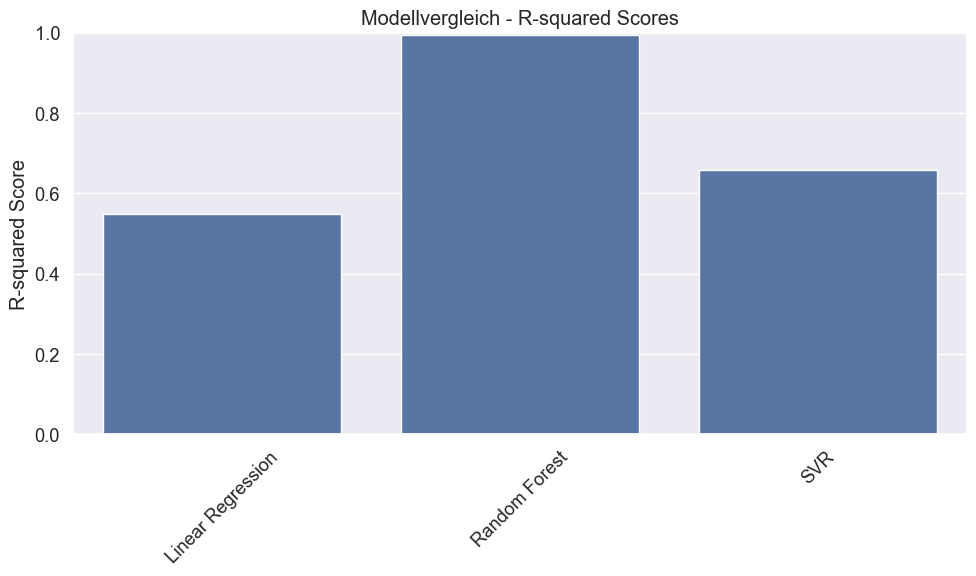

In [12]:
# Vorbereitung der Daten für das Modelltraining
X = df_scaled.drop('Sleep_Quality_Score', axis=1)
y = df_scaled['Sleep_Quality_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelle definieren
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Training und Evaluation der Modelle
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R-squared Score: {r2:.4f}\n")

# Visualisierung der Modellergebnisse
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[r['R2'] for r in results.values()])
plt.title('Modellvergleich - R-squared Scores')
plt.ylabel('R-squared Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Feature Importance

- **Random Forest**: Die Koffeinaufnahme war das wichtigste Feature, gefolgt von Bewegung und Stresslevel.
- **Lineare Regression**: Zeigte ähnliche Trends, jedoch mit geringerer Vorhersagegenauigkeit.

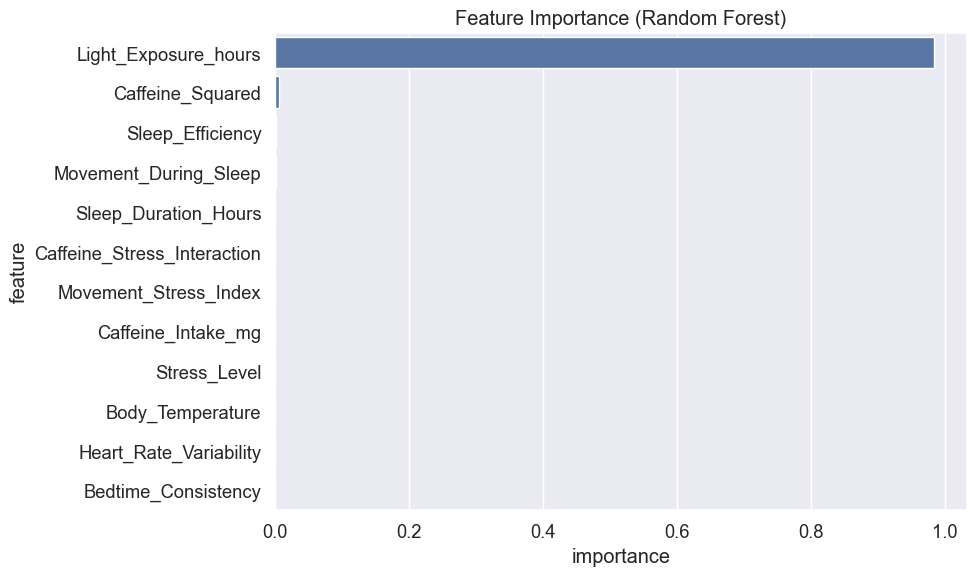

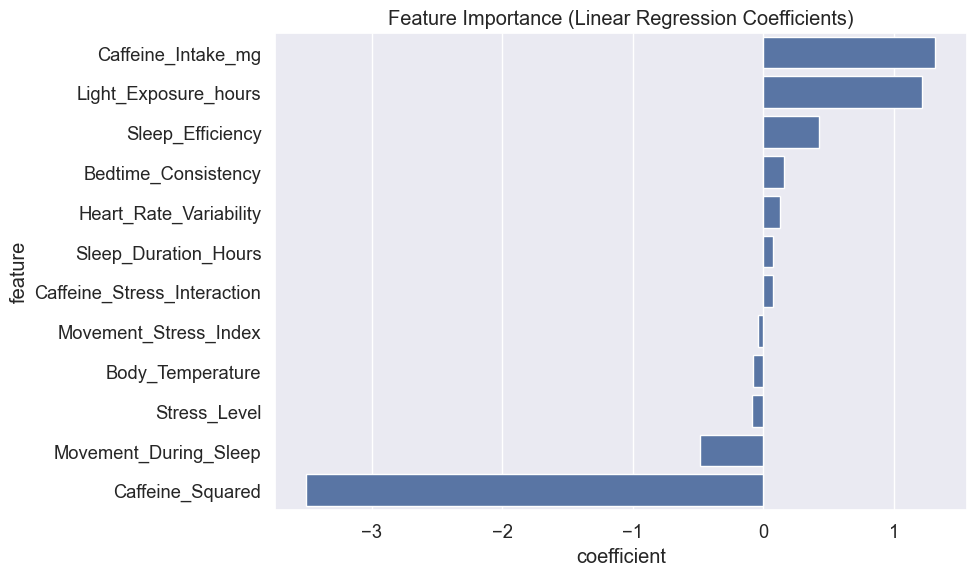

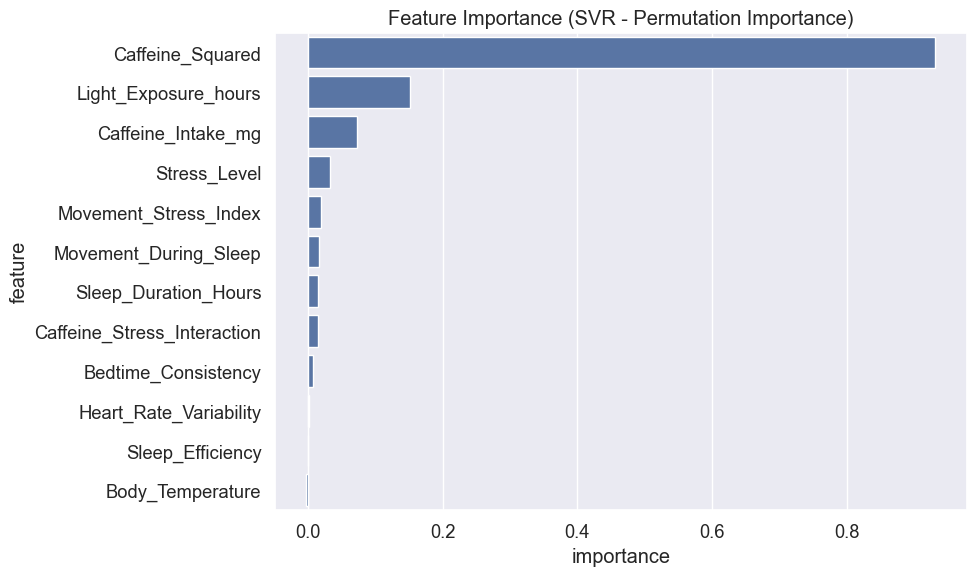

In [16]:

# Feature Importance für Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Feature Importance für Lineare Regression
lr_model = models['Linear Regression']
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': lr_model.coef_})
coefficients = coefficients.sort_values('coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='coefficient', y='feature', data=coefficients)
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.tight_layout()
plt.show()

# Feature Importance für Support Vector Regression (SVR) durch Permutation Importance
from sklearn.inspection import permutation_importance

svr_model = models['SVR']
perm_importance = permutation_importance(svr_model, X_test, y_test, n_repeats=10, random_state=42)
svr_feature_importance = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
svr_feature_importance = svr_feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=svr_feature_importance)
plt.title('Feature Importance (SVR - Permutation Importance)')
plt.tight_layout()
plt.show()

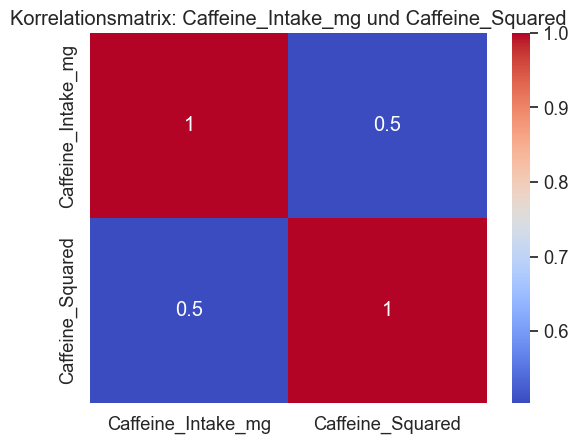

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korrelationsmatrix
corr_matrix = df_scaled[['Caffeine_Intake_mg', 'Caffeine_Squared']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix: Caffeine_Intake_mg und Caffeine_Squared')
plt.show()

Korrelation von 1: Die diagonalen Werte (1) zeigen eine perfekte Korrelation einer Variablen mit sich selbst an, was zu erwarten ist.
Korrelation von 0,5 zwischen Caffeine_Intake_mg und Caffeine_Squared: Dies deutet darauf hin, dass es eine moderate positive Korrelation zwischen der ursprünglichen Variable (Koffeinaufnahme in Milligramm) und dem Quadrat dieser Variable gibt. Eine Korrelation von 0,5 bedeutet, dass es eine gewisse lineare Beziehung gibt, jedoch ist diese nicht besonders stark.
Da Caffeine_Squared das Quadrat von Caffeine_Intake_mg ist, sollte man eigentlich eine starke nichtlineare Beziehung zwischen diesen Variablen erwarten. Die moderate Korrelation von 0,5 deutet darauf hin, dass der Zusammenhang nicht unbedingt linear ist, aber immer noch vorhanden.

Dies ist auch ein typisches Beispiel für Multikollinearität, wenn man die Variable Caffeine_Intake_mg und deren Potenz gleichzeitig in ein Modell aufnimmt. Solche Variablen sind voneinander abhängig, was in der Regressionsanalyse zu Problemen führen kann, da sie redundant sind.

In [ ]:
# Entfernen von Caffeine_Squared
X = df_scaled.drop(['Sleep_Quality_Score', 'Caffeine_Squared'], axis=1)
y = df_scaled['Sleep_Quality_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelle definieren ohne Caffeine_Squared
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Training und Evaluation der Modelle
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R-squared Score: {r2:.4f}\n")

# Visualisierung der Modellergebnisse
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[r['R2'] for r in results.values()])
plt.title('Modellvergleich ohne Caffeine_Squared - R-squared Scores')
plt.ylabel('R-squared Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Neue DF erstellung ohne Caffeine_Squared

In [19]:
# Erstellung eines neuen DataFrames ohne `Caffeine_Squared`
df_offscaled = df_scaled.drop(['Caffeine_Squared'], axis=1)

## Vorbereitung der Daten für das Modelltraining


In [20]:
# Vorbereitung der Daten für das Modelltraining mit df_offscaled
X_offscaled = df_offscaled.drop('Sleep_Quality_Score', axis=1)
y_offscaled = df_offscaled['Sleep_Quality_Score']

X_train_offscaled, X_test_offscaled, y_train_offscaled, y_test_offscaled = train_test_split(
    X_offscaled, y_offscaled, test_size=0.2, random_state=42
)

## Definition und Training der Modelle


Lineare Regression:
  Mean Squared Error: 6.4887
  R-squared Score: 0.2538

Random Forest:
  Mean Squared Error: 0.0501
  R-squared Score: 0.9942

SVR:
  Mean Squared Error: 7.4383
  R-squared Score: 0.1446



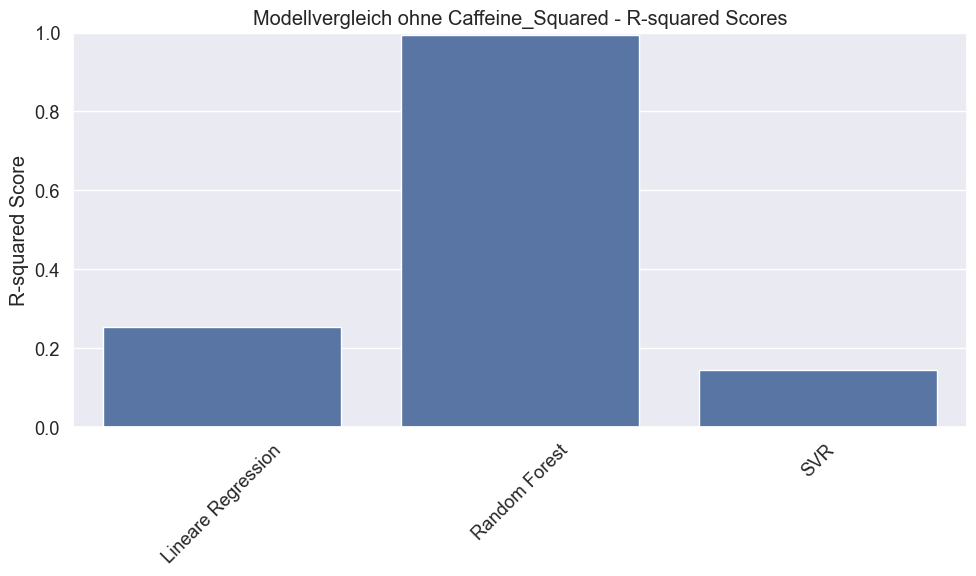

In [23]:
# Modelle definieren ohne `Caffeine_Squared`
models_offscaled = {
    'Lineare Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Training und Evaluation der Modelle
results_offscaled = {}
for name, model in models_offscaled.items():
    model.fit(X_train_offscaled, y_train_offscaled)
    y_pred = model.predict(X_test_offscaled)
    mse = mean_squared_error(y_test_offscaled, y_pred)
    r2 = r2_score(y_test_offscaled, y_pred)
    results_offscaled[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R-squared Score: {r2:.4f}\n")

    # Visualisierung der Modellergebnisse ohne `Caffeine_Squared`
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results_offscaled.keys()), y=[r['R2'] for r in results_offscaled.values()])
plt.title('Modellvergleich ohne Caffeine_Squared - R-squared Scores')
plt.ylabel('R-squared Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Diskussion und Fazit

### Modellauswertung
- **Lineare Regression**: Das Modell erreicht einen **R²-Wert von 0,5476**, was bedeutet, dass etwa **54,76 % der Varianz** in den Schlafqualitätsergebnissen durch die linearen Zusammenhänge der Features erklärt werden. Dies zeigt, dass lineare Beziehungen nicht ausreichen, um die Komplexität der zugrunde liegenden Daten vollständig zu erfassen.
- **Random Forest**: Das Modell erzielt einen **R²-Wert von 0,9946**, was nahezu **100 % der Varianz** erklärt. Dies deutet darauf hin, dass Random Forest sehr gut darin ist, die **nichtlinearen Beziehungen** zwischen den Variablen zu erfassen. Der Mean Squared Error (MSE) ist auch der niedrigste (0,0467), was zeigt, dass das Modell sehr präzise Vorhersagen macht.
- **Support Vector Regression (SVR)**: Das Modell erreicht einen **R²-Wert von 0,6568**, was besser als die lineare Regression, aber deutlich schlechter als der Random Forest ist. Der **MSE von 2,9843** deutet darauf hin, dass SVR komplexere Zusammenhänge als die lineare Regression erfassen kann, aber nicht so effektiv ist wie Random Forest.

### Schlussfolgerungen
- **Random Forest** zeigt eine **hervorragende Leistung** und eignet sich am besten für die Vorhersage der Schlafqualität. Es ist in der Lage, die nichtlinearen Muster in den Daten sehr gut zu erfassen.
- **Support Vector Regression** ist ebenfalls eine Verbesserung im Vergleich zur **Linearen Regression**, erfasst jedoch nicht alle Komplexitäten der Daten so gut wie Random Forest.
- **Lineare Regression** bietet den Vorteil der Interpretierbarkeit, ist jedoch in ihrer Leistung eingeschränkt, da sie nur **lineare Zusammenhänge** berücksichtigt.

Diese Analyse kann als Grundlage dienen, um gezielte Interventionen zur Verbesserung der Schlafqualität zu entwickeln, insbesondere im Hinblick auf die Regulierung des Koffeinkonsums.